In [1]:
%load_ext autoreload
%autoreload 2
from collections import OrderedDict
from datasets import load_dataset
from more_itertools import chunked
from itda import ITDAConfig, ITDA
from tqdm.auto import tqdm
import numpy, torch
import json, os
os.makedirs("dataset", exist_ok=True)

In [2]:
import torch
from diffusers import FluxPipeline

pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16, device_map="balanced")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
torch.set_grad_enabled(False)

In [4]:
import numpy as np
nf4 = np.asarray(
    [
        -1.0,
        -0.6961928009986877,
        -0.5250730514526367,
        -0.39491748809814453,
        -0.28444138169288635,
        -0.18477343022823334,
        -0.09105003625154495,
        0.0,
        0.07958029955625534,
        0.16093020141124725,
        0.24611230194568634,
        0.33791524171829224,
        0.44070982933044434,
        0.5626170039176941,
        0.7229568362236023,
        1.0,
    ]
)
image_max = 6.0

In [6]:
prompts_dataset = load_dataset("opendiffusionai/cc12m-cleaned")
prompts_iterator = prompts_dataset["train"]["caption_llava_short"]
guidance_scale = 3.5
num_inference_steps = 1
batch_size = 32
width = 256
height = 256
d_model = 3072

In [7]:
normalize = False
device = "cuda"

In [46]:
from caching_utils import save_itda_outputs
from scored_storage import ScoredStorage
from pathlib import Path

topk = 64

feature_acts = ScoredStorage(
    Path("mlp_data") / "feature_acts.db",
    3, topk
)

In [47]:
images_dir = Path("images_mlp")
images_dir.mkdir(exist_ok=True)

image_activations_dir = Path("image_activations_mlp")
image_activations_dir.mkdir(exist_ok=True)

In [50]:
for i, prompts in enumerate(chunked((bar := tqdm(prompts_iterator[10000:15000])), batch_size)):
    with torch.inference_mode():
        for m in pipe.transformer.modules():
            m._forward_hooks = OrderedDict()
        # text_outputs = {}
        image_outputs = {}
        timestep = 0
        def save_hook(self, input, output):
            # text_outputs[timestep] = output[0]
            image_outputs[timestep] = output#[1]
        pipe.transformer.transformer_blocks[18].ff.net[0].register_forward_hook(save_hook)
        height = 256
        width = 256
        def callback_on_step_end(self, i, t, kwargs):
            global timestep
            timestep = i
            return {}
        pipe.set_progress_bar_config(disable=True)
        with torch.inference_mode():
            latents = pipe(
                prompts,
                height=height,
                width=width,
                guidance_scale=guidance_scale,
                num_inference_steps=num_inference_steps,
                max_sequence_length=512,
                generator=torch.Generator("cpu").manual_seed(0),
                return_dict=False,
                callback_on_step_end=callback_on_step_end,
                output_type="latent",
            )[0]
        latents_reshaped = pipe._unpack_latents(latents, height, width, pipe.vae_scale_factor)
        latents_to_be_compressed = latents_reshaped.cpu().float().numpy()
        
        # break

        # if normalize:
        #     if stds is None:
        #         stds = x.std(dim=0, unbiased=False)
        #     x = x / stds

        weights, indices = image_outputs[0].cpu().float().topk(topk, dim=-1)

        weights = weights.float().cpu().numpy()
        indices = indices.cpu().numpy()


        save_itda_outputs(
            weights, indices, prompts=prompts, images=latents_to_be_compressed, feature_acts=feature_acts, save_image_activations=True, step=i, 
            images_dir=images_dir, image_activations_dir=image_activations_dir
        )

  0%|          | 0/5000 [00:00<?, ?it/s]

In [43]:
vv, ii = image_outputs[0].cpu().float().topk(64, dim=-1)

In [45]:
vv.shape

torch.Size([32, 256, 64])

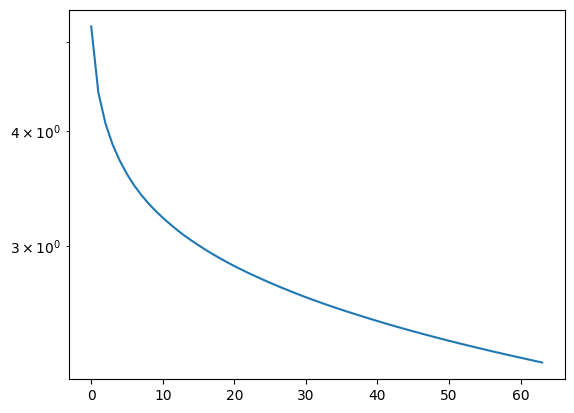

In [44]:
import matplotlib.pyplot as plt
plt.plot(vv.mean((0, 1)).cpu().numpy())
plt.yscale("log")
plt.show()

(array([1.651614e+06, 9.895230e+05, 1.016550e+05, 7.402800e+04,
        5.791100e+04, 4.534200e+04, 3.782300e+04, 3.046500e+04,
        2.627200e+04, 2.266600e+04, 1.887600e+04, 1.482700e+04,
        1.327600e+04, 1.128800e+04, 9.193000e+03, 7.318000e+03,
        6.685000e+03, 4.542000e+03, 4.313000e+03, 3.161000e+03,
        2.847000e+03, 2.557000e+03, 1.674000e+03, 1.402000e+03,
        1.236000e+03, 1.122000e+03, 7.750000e+02, 6.050000e+02,
        4.980000e+02, 4.250000e+02, 3.800000e+02, 2.280000e+02,
        2.370000e+02, 1.860000e+02, 1.550000e+02, 1.180000e+02,
        8.500000e+01, 7.800000e+01, 5.900000e+01, 4.400000e+01,
        4.200000e+01, 2.600000e+01, 3.100000e+01, 1.700000e+01,
        1.300000e+01, 1.400000e+01, 1.000000e+01, 1.500000e+01,
        7.000000e+00, 1.000000e+01, 1.200000e+01, 5.000000e+00,
        4.000000e+00, 4.000000e+00, 3.000000e+00, 0.000000e+00,
        4.000000e+00, 1.000000e+00, 5.000000e+00, 1.000000e+00,
        0.000000e+00, 1.000000e+00, 0.00

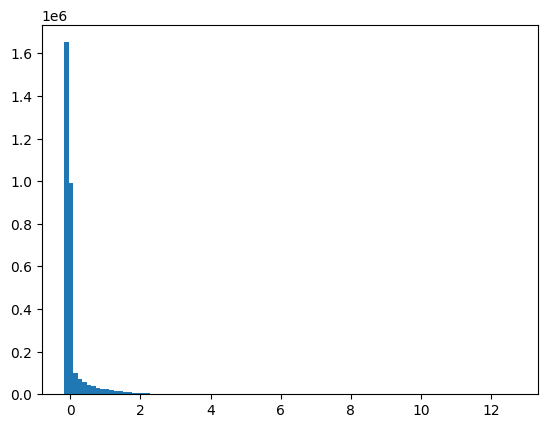

In [20]:
import matplotlib.pyplot as plt

plt.hist(image_outputs[0].cpu().float().numpy().flatten(), bins=100)